In [8]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Helper: Haversine distance
# ---------------------------
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculates the great-circle distance between two points on Earth.
    Useful for detecting transactions far from usual customer locations.
    """
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# --------------------------
# Load and preprocess data
# --------------------------
train_df = pd.read_csv("C:/Users/kadus/OneDrive/Desktop/intern/fraudTrain.csv")
test_df = pd.read_csv("C:/Users/kadus/OneDrive/Desktop/intern/fraudTest.csv")

# Drop irrelevant or high-cardinality columns that could leak data or aren't generalizable
cols_to_drop = [
    'trans_num',                # Transaction ID (string)
    'trans_date_trans_time',    # Timestamp (string)
    'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'unix_time', 'job', 'merchant'  # Private details
]
train_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')
test_df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# ------------------------
# Add Geospatial Features
# ------------------------
for df in [train_df, test_df]:
    df['distance_km'] = df.apply(
        lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1
    )
    df['is_far'] = (df['distance_km'] > df['distance_km'].quantile(0.95)).astype(int)

# Drop raw geolocation columns now that distance has been extracted
train_df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'], inplace=True)
test_df.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'], inplace=True)



# --------------------------
# One-Hot Encode Categorical Variables
# --------------------------
# Identify categorical columns and apply one-hot encoding
categorical_cols = ['gender', 'category']  # For simplicity, using low-cardinality columns
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_cols, drop_first=True)

# Align test and train sets to ensure they have the same columns after one-hot encoding
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

# --------------------------
# Split Features and Labels
# --------------------------
X_train = train_df.drop("is_fraud", axis=1)
y_train = train_df["is_fraud"]
X_test = test_df.drop("is_fraud", axis=1)
y_test = test_df["is_fraud"]

# --------------------------
# Feature Scaling
# --------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [11]:
# Compute Scale for Imbalanced Classes
# --------------------------
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# --------------------------
# Hyperparameter Optimization using GridSearchCV
# --------------------------
param_grid = {
    'learning_rate': [0.01],
    'max_depth': [3],
    'n_estimators': [ 200],
    'subsample': [0.9],
    'colsample_bytree': [ 1.0]
}

grid_search = GridSearchCV(XGBClassifier(eval_metric='logloss', use_label_encoder=False), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best parameters found through GridSearch
print("Best parameters found: ", grid_search.best_params_)


C:\Users\kadus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [16:22:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}


C:\Users\kadus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [16:25:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


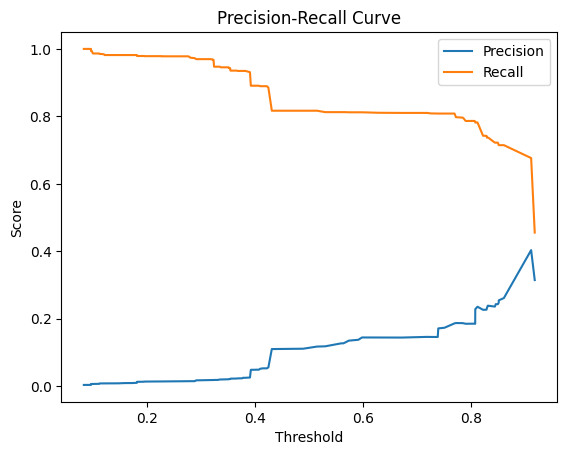

Confusion Matrix:
 [[551446   2128]
 [  1168    977]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.31      0.46      0.37      2145

    accuracy                           0.99    555719
   macro avg       0.66      0.73      0.68    555719
weighted avg       1.00      0.99      0.99    555719

ROC-AUC Score: 0.9681807149460977


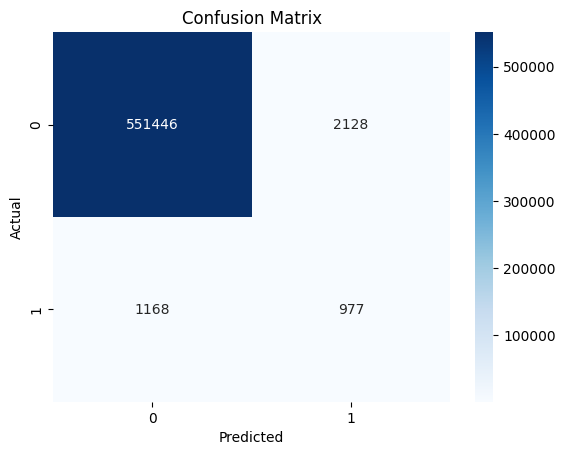

In [13]:
# --------------------------
# Train XGBoost Model with Best Parameters
# --------------------------
best_model = grid_search.best_estimator_

# --------------------------
# Adjust Class Weight (for imbalanced data)
# --------------------------
best_model.set_params(scale_pos_weight=scale_pos_weight)

# Train the model
best_model.fit(X_train_scaled, y_train)

# --------------------------
# Adjust Threshold using Precision-Recall Curve
# --------------------------
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Get precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot the curve to select a threshold
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

## Find the index of the best precision but make sure it doesn't exceed len(thresholds) - 1
best_index = np.argmax(precision[:-1])  # ignore last precision value
optimal_threshold = thresholds[best_index]

y_pred_adjusted = (y_pred_prob > optimal_threshold).astype(int)

# --------------------------
# Model Evaluation
# --------------------------
# Evaluate with adjusted threshold
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_adjusted))
print("\nClassification Report:\n", classification_report(y_test, y_pred_adjusted))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))

# --------------------------
# Confusion Matrix Visualization
# --------------------------
sns.heatmap(confusion_matrix(y_test, y_pred_adjusted), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [16]:
from sklearn.linear_model import LogisticRegression


# Combine XGBoost with Random Forest and Logistic Regression
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', best_model),
        ('lr', LogisticRegression(max_iter=1000)),
        ('rf', RandomForestClassifier())
    ],
    voting='soft'  # Use predicted probabilities
)

voting_clf.fit(X_train_scaled, y_train)

# Evaluate the ensemble model
y_pred_ensemble = voting_clf.predict(X_test_scaled)
print("Confusion Matrix (Ensemble):\n", confusion_matrix(y_test, y_pred_ensemble))
print("\nClassification Report (Ensemble):\n", classification_report(y_test, y_pred_ensemble))

C:\Users\kadus\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [16:33:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix (Ensemble):
 [[552870    704]
 [   863   1282]]

Classification Report (Ensemble):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.65      0.60      0.62      2145

    accuracy                           1.00    555719
   macro avg       0.82      0.80      0.81    555719
weighted avg       1.00      1.00      1.00    555719

